# Credit assignment through regression discontinuity design


## 1.1 The problem

In the following we consider a small network of spiking neurons $\mathbf{h} \in \mathbb{R}^n$ which is able to observe a cost function/reward signal, $C(x,y,W)$, for some computation that it is involved in. 

To adjust its weights to minimize this cost function a neuron must know the gradient:
$$
\beta_i \equiv \frac{\partial C}{\partial h_i}.
$$

This can be computed through backpropagation, $\beta_i^{BP} \equiv \beta_i$, however there are few known biologically plausible mechanisms for implementing backprop. Though some candidates have appeared recently. For instance the method of synthetic gradients uses reinforcement-learning style estimators for the gradient, $\hat{\beta}_i^{SG} \approx \beta_i^{BP}$, which addresses some of the issues with backprop.

Alternatively, in cases where the cost function is observed by the neuron, it could learn $\beta_i$ from this feedback. A na\"ive approximation of $\beta_i$ could proceed via a type of finite differences approach:
$$
\beta_i^{FD} \equiv \mathbb{E}(C|h_i = 1) - \mathbb{E}(C|h_i=0).
$$

An issue with the above estimator is that it is effectively only measuring the correlation between $h_i$ and $C$. Note that under the hypothetical scenario that backprop has a plausible implementation mechanism, backprop provides a _causal_ measure of $\beta_i$. That is, via backprop the neuron learns directly about its effect on $C$ through all of its downstream connections. If, at some point downstream of $h_i$, all of the weights through which $h_i$ may affect $C$ are zero then backprop will correctly report $\beta_i = 0$. 

The estimator based on $\beta_i^{FD}$ on the other hand can be biased by correlations with other neurons. For instance, we can imagine in the same no-effect scenario ($\beta_i = 0$) that $\beta_i^{FD}$ could be non-zero provided there was  another neuron $h_j$ whose activity was correlated with $h_i$ and for which there were non-zero downstream weights such that $\beta_j \ne 0$. 

The credit assignment problem in this correlated activity case is thus a challenge: how does a neuron learn _its_ specific effect on a cost function when its neighbors are correlated with its activity? Spike train correlations and their effect on coding have been well-studied (Shea-Brown studies...). (Things to do with spike time correlations and learning) (Mention node-perturbation methods)

## 1.2 The model

We will demonstrate our idea via a simple test system of $n=2$ leaky integrate and fire (LIF) neurons. The neurons thus obey
$$
\dot{v}_i = -g_L v_i + w_i\eta_i
$$
for $i = 1,2$. Integrate and fire means simply:
$$
v_i(t^+) = v_r, \quad \text{when }v_i(t) = \mu.
$$

Noisy input $\eta_i$ is comprised of a common DC current, $x$, and noise term, $\xi(t)$, plus an individual noise term, $\xi_i(t)$:
$$
\eta_i(t) = x + \sigma_i\left[\sqrt{1-c}\xi_i(t) + \sqrt{c}\xi(t)\right].
$$
The noise processes are independent white noise: $\mathbb{E}(\xi_i(t)\xi_j(t')) = \delta_{ij}\delta(t-t')$. This parameterization is chosen so that the inputs $\eta_{1,2}$ have correlation coefficient $c$. Output spike trains are defined as
$$
y_i(t) = \sum_s \delta(t-t_i^s)
$$
for $t_i^s$ the $s$th spike time.

In what follows simulations are performed with a step size of $\Delta t = 1ms$. Thus outputs at each time step become indicator functions:
$$
h_i^t = \mathbb{1}(\text{$i$ spikes in timebin $t$}).
$$

## 1.3 Some background

### Potential outcomes and causal effect

The Rubin causal model (RCM) provides a framework for reasoning about causal effects in terms of counterfactuals. In a simple setting, the model considers two _potential outcomes_: an outcome when a subject does receive a treatment, $Y(1)$, and an outcome when a subject does not receive a treatment, $Y(0)$ (i.e. a control subject). For a given subject, the _causal effect_ is the difference in potential outcomes:
$$\begin{equation}
 E_i = Y_i(1)-Y_i(0).
\end{equation}
$$

The _fundamental problem of causal inference_ is that, per subject, only one of these outcomes is ever observed. Either the subject receives the treatment, or does not -- one of $Y_i(0)$ or $Y_i(1)$ is a counterfactual, a what-if. In general causal effects must therefore be measured at a (sub)population level. This motivates considering the _average causal effect_:
$$
\begin{equation}
 \beta = \mathbb{E}(Y(1)-Y(0)).
\end{equation}
$$

If we let $W_i$ be a treatment random variable:

$$\begin{equation}
 W_i = \begin{cases}
        1, & \text{subject $i$ receives treatment};\\
        0, & \text{subject $i$ assigned control};
       \end{cases}
\end{equation}$$

then the observed outcome is
$$
\begin{equation}
 Y_i = W_iY_i(1) + (1-W_i)Y_i(0).
\end{equation}
$$

If $W_i$ is assigned to each subject at random (a randomized control trial) then $\beta$ can be computed directly from the treatment and control subpopulation means. In randomized cases, $W_i$ is independent from the potential outcomes. If $W_i$ were not independent from the potential outcomes then the measured causal effect (difference in means) could simply be a result of this correlation. (If a treatment is preferentially given to subjects with cancer, then we should of course expect to see a difference in cancer rates between treated and control groups.) A requirement for causal inference is therefore

$$\begin{equation}
 Y(1),Y(0) \perp W.
\end{equation}$$

In most cases of interest both the outcome and treatment variable are related to a set of observed covariates, $X$. Causal inference then requires:
$$\begin{equation}
 Y(1),Y(0) \perp W | X,
\end{equation}$$
which is called the _unconfoundedness assumption_.

Causal effect cannot be inferred among populations that either always receive treatment or do not. Thus, additionally, causal inference requires a non-zero probability of assignment to a treatment group for all subjects:

$$\begin{equation}
 0 < \mathbb{P}(W_i = 1|X_i = x) < 1 \quad \forall x.
\end{equation}$$
This is known as the _positivity_, or overlap, assumption.  Note that these are not the only assumptions typically made in this framework, just those relevant to describing regression discontinuity design. Often also invoked is: the 'stable unit treatment value assumption' (SUTVA) -- treatment of subjects are stable, do not interfere with one another and only take one form; and consistency -- the potential outcome $Y(W)$ matches the observed outcome $Y$ under $W$.

### Regression discontinuity design

Regression discontinuity (RD) design \cite{Imbens2008} is applicable in cases where treatment assignment is performed by thresholding on a covariate. In what follows let $X$ be this covariate and $Z$ be the remaining covariates. 
Thus, 
$$\begin{equation}
 W_i = \begin{cases}
        1, & X_i \ge \mu\\
        0, & X_i < \mu.
       \end{cases}
\end{equation}$$

The intuition behind RD design is that for subjects close to the threshold, $X_i \approx \mu$, whether or not treatment is received is essentially random, and the difference in observed outcome just below and above the threshold provides a measure of causal effect.

Thus we can estimate causal effect at $X=\mu$ via
$$\begin{align}
\beta_{RD} &= \mathbb{E}(Y(1)-Y(0)|X = \mu)\\
&= \lim_{x \to \mu^+}\mathbb{E}(Y|X = x) - \lim_{x\to \mu^-}\mathbb{E}(Y|X = x).
\end{align}$$

Note that the unconfoundedness assumption is satisfied trivially since, conditioned on $X$, $W$ is deterministic and therefore independent of potential outcomes. This deterministic assignment violates the positivity assumption, however. Thus RD design requires an additional continuity assumption:
$$\begin{equation}
\mathbb{E}(Y(0)|X = x) \text{ and } \mathbb{E}(Y(1)|X = x)
\end{equation}$$
are continuous in $x$. This ensures that an observed discontinuity in means is attributable to average causal effect, and not just discontinuous potential outcomes. 

Average causal effect can be estimated through nonparametric kernel regression, applied separately on either side of the threshold. Alternatively, a local linear regression can be performed on either side of the threshold, within a window of width $p$:
$$\begin{equation}
 Y = \begin{cases}
 \beta_l + \alpha_l (X-\mu)& \mu - p \le X < \mu \\
 \beta_r + \alpha_r (X-\mu)& \mu \le X \le \mu + p.
 \end{cases}
\end{equation}$$

The causal effect can then be inferred from the difference in estimated terms
$$\begin{equation}
\hat{\beta} = \hat{\beta_r} - \hat{\beta_l}.
\end{equation}$$

## 2 Estimation of $\beta_i$

## 2.1 Separating correlation and causation

We make the ideas from Section 1 about estimating $\beta_i$ a bit more formal. Let an input $x$ be fixed, but $\{h_i\}_{i=1}^n$ have a stochastic component such that $h_i$ and $C$ are both random variables. Let $\mathbf{h}$ be the random vector $(h_i)_{i=1}^n$. In a deterministic spiking network we could approximate $\beta_i$ via
$$
\beta_i \approx C(\mathbf{h}_{j\ne i}, h_i=1) - C(\mathbf{h}_{j\ne i}, h_i=0).
$$

The equivalent in a stochastic setting is a quantity that measures the change in $C$ given a change in $h_i$, with all other variables known. This is captured by the conditional expectation
$$
\beta_i = \mathbb{E}\left[\mathbb{E}\left[C|\mathbf{h}_{j\ne i},h_i = 1\right] - \mathbb{E}\left[C|\mathbf{h}_{j\ne i}, h_i=0\right]\right].
$$

The directed acyclic graph (DAG) that describes this setup is shown in Figure 1. Inspection of the DAG shows that the set of nodes $\{h_j\}_{j\ne i}$ satisfy the backdoor criteria with respect to $h_i \to C$, and are thus sufficient controls to provide an estimate of the causal effect of $h_i$ on $C$. This means we can interpret $\beta_i$ as a measure of average causal effect:
$$
\beta_i = \mathbb{E}\left[C|do(h_i=1)\right] - \mathbb{E}\left[C|do(h_i=0)\right].
$$

The problem with this estimator is that a neuron $h_i$ does not observe the other neurons' activity, which are the controls necessary to infer $\beta_i$.

A neuron could take 
$$
\beta_i^{FD} = \mathbb{E}(C|h_i=1) - \mathbb{E}(C|h_i=0)
$$
but this only provides an estimate of $\beta_i$ when $h_i \perp \mathbf{h}_{j\ne i}$. This follows because
$$
\begin{align}
\beta_i^{FD} &= \mathbb{E}(C|h_i=1) - \mathbb{E}(C|h_i=0)\\
             &= \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=1) | h_i=1) - \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=0) | h_i=0)\\
          \text{(by independence)}\quad   &= \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=1)) - \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=0))\\
          &= \beta_i.
\end{align}
$$
In general, $\beta_i^{FD}$ is biased. Therefore some other means is needed to estimate $\beta_i$ in a neuron that observes only its activity and $C$. 

We could imagine a neuron performing its own 'randomized control trial', in which it perturbs its output, independent of its inputs, and notes the effect on the cost function of its perturbations. This is known as node-perturbation (citations). While it does provide a measure of average causal effect, it requires the proposition that a neuron possesses a type of 'experimentation mode', randomized spiking independent from its inputs, that it uses to learn its cost gradient. It is unclear how a neuron may acheive this, nor if it is the most efficient way for it to learn $\beta_i$.

![DAG](dag.svg)
**Figure 1.** Input $x$ plus common noise $\xi$ drive spiking units $h_i$, which permits calculation of cost function $C$. Interpretting as a causal graph shows conditioning on $\mathbf{h}_{j\ne i}$ is sufficient to control for confounding and infer causal effect of $h_i$ on $C$.


## 2.2 Regression discontinuity design

Here we propose a modification of the FD estimator that draws on methods from causal inference, and that can recover an unbiased estimator of $\beta_i$, thus obviating the need for backprop or an 'experimentation mode'.

In essence, a neuron's activity is characterized by thresholded events -- spikes. We propose that this can be utilized by a neuron,  via RD design, to infer the effect of its activity on a cost function. To achieve this we propose that a neuron (compartment?) implicitly learns an estimate of the cost function of the form:
$$
C = \alpha_i v_i + \beta_i h_i + \gamma_i + \epsilon.
$$
where $v_i$ is membrane potential, $h_i$ acts as an indicator function for neuron $i$ spiking, constant term $\gamma_i$, and zero-mean error $\epsilon$. For simplicity we assume parameters $\alpha_i$ and $\gamma_i$ are the same below and above threshold. By estimating $\beta_i$ the neuron estimates its causal effect:
$$
\beta_i^{RD} \equiv \lim_{x \to \mu^+} \mathbb{E}(C|v_i = x) - \lim_{x \to \mu^-} \mathbb{E}(C|v_i=x)
$$

Thus, within a window $p$ of $v_i = \mu$:
$$\begin{align}
 \beta_i &\approx \mathbb{E}_{\mu \le v_i < \mu+p}(C-\alpha v_i-\gamma_i) - \mathbb{E}_{\mu - p < v_i < \mu} (C-\alpha v_i-\gamma_i)\\
 &= \mathbb{E}_{\mu-p < v_i < \mu + p}([2h_i - 1][C-\alpha v_i - \gamma_i]).
\end{align}$$



## 2.3 An RD learning rule

## 3 Simulations

In each timebin a cost function can then be defined as
$$
C_t(\mathbf{h}_t; x, \mathbf{w}) = (v_1 h_1^t + v_2h_2^t - x^2)^2.
$$

We simulate this system below, and show how the various estimators of $\beta_i$ relate to each other for different values of $c$ and $v_{1,2}$.

In [214]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand

dt = 0.001         #Step size
t = 5              #Simulation time
tr = 0.003         #Refractory period
mu = 1             #Threshold
reset = 0          #Reset potential
xsigma = 1         #Std dev of input x
n = 2              #Number of neurons
tau = 1            #Time constant
c = .99            #Correlation between noise inputs
sigma = 15          #Std dev of noise process

In [215]:
#Initialize voltage and spike train variables
T = np.ceil(t/dt).astype(int)
Tr = np.ceil(tr/dt).astype(int)
times = np.linspace(0,t,T)

v = np.zeros((n,T))
h = np.zeros((n,T))
vt = np.zeros(n)
r = np.zeros(n)

#Choose a random input x, input, output weights, and noise processes
#x = abs(rand.randn()*xsigma)+10
#W = 5*rand.randn(2)
V = 5*rand.randn(2)

#Or just make these deterministic
x = 5
W = np.array([5, 5])

xi = sigma*rand.randn(n+1,T)/np.sqrt(tau)
xi[0,:] = xi[0,:]*np.sqrt(c)
xi[1:,:] = xi[1:,:]*np.sqrt(1-c)

In [216]:
#Simulate T seconds
for i in range(T):
    dv = -vt/tau + np.multiply(W,(x + xi[0,i] + xi[1:,i]))
    vt = vt + dt*dv
    #Find neurons that spike
    s = vt>mu
    #Make them refractory
    r[s] = Tr
    #Set the refractory neurons to v_reset
    v[:,i] = vt
    vt[r>0] = reset
    vt[vt<reset] = reset
    #Decrement the refractory counters
    r[r>0] -= 1
    #Save the voltages and spikes
    h[:,i] = s.astype(int)
        
#Cost function per time point
C = (V[0]*h[0,:]+V[1]*h[1,:]-x**2)**2

In [217]:
v[:,0:10]

array([[-0.05118895,  0.13587637,  0.16207011,  0.22661386,  0.27086887,
         0.30943178,  0.38548125,  0.40672823,  0.5445834 ,  0.52316759],
       [-0.0483413 ,  0.12983958,  0.14670665,  0.18871201,  0.23522237,
         0.28902245,  0.35767916,  0.39490286,  0.53108595,  0.51959573]])

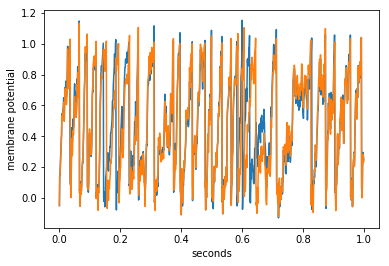

In [218]:
#Plot cost as a function of membrane potential of each neuron
t_idx = range(1000)
plt.plot(times[t_idx],v[0,t_idx], times[t_idx],v[1,t_idx])
plt.xlabel('seconds')
plt.ylabel('membrane potential')
#Make similar plots for different values of c


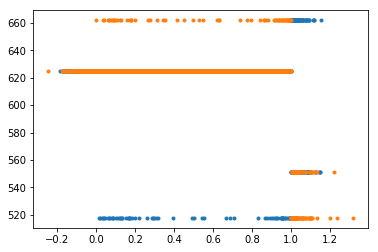

In [219]:
#Plot cost as a function of membrane potential
plt.plot(v[0,:], C, '.', v[1,:], C,'.')

## 4. Discussion